# Import Libraries

In [36]:
import pickle
import numpy as np
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Load Data

In [37]:
with open('./Datasets/citeseer/edge_index.pkl', 'rb') as f:
    edge_index = pickle.load(f)
with open('./Datasets/citeseer/features.pkl', 'rb') as f:
    features = torch.from_numpy(pickle.load(f).toarray())
with open('./Datasets/citeseer/node_labels.pkl', 'rb') as f:
    node_labels = pickle.load(f)

In [38]:
train_size = np.ceil(len(node_labels) *0.6)
val_size = np.ceil(len(node_labels) *0.1)
test_size = len(node_labels) - train_size - val_size

test_train_val = np.concatenate((np.ones(int(train_size),dtype=np.int),np.zeros(int(val_size),dtype=np.int),np.full(shape=int(test_size),fill_value=2,dtype=np.int)))
np.random.shuffle(test_train_val)

C:\Windows\TEMP/ipykernel_11376/1555867491.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_train_val = np.concatenate((np.ones(int(train_size),dtype=np.int),np.zeros(int(val_size),dtype=np.int),np.full(shape=int(test_size),fill_value=2,dtype=np.int)))


In [39]:
train_mask = test_train_val ==1
test_mask = test_train_val ==2
val_mask = test_train_val ==0

In [40]:
dataset= Data(x=features, edge_index=edge_index, y=node_labels, num_classes=6, train_mask =train_mask, test_mask=test_mask, val_mask=val_mask )

In [41]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')

print(f'Number of classes: {dataset.num_classes}')

data = dataset # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], num_classes=6, train_mask=[3327], test_mask=[3327], val_mask=[3327]):
Number of graphs: 7
Number of features: 3703
Number of classes: 6

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], num_classes=6, train_mask=[3327], test_mask=[3327], val_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Has isolated nodes: True
Has self-loops: False
Is undirected: True


# Define Model

In [42]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
    

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

GCN(
  (conv1): GCNConv(3703, 128)
  (conv2): GCNConv(128, 6)
)


# Training

In [46]:
def train(epochs, data, loss_func,optimizer, learning_rate):
    criterion = loss_func()
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    model.train()
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(epochs):
        out = model(data.x, data.edge_index)
        loss_train = criterion(out[data.train_mask], data.y[data.train_mask])
        loss_val = criterion(out[data.val_mask], data.y[data.val_mask])
        pred = out.argmax(dim=1) 
        train_correct = pred[data.train_mask] == data.y[data.train_mask]  
        acc_train = int(train_correct.sum()) / int(data.train_mask.sum()) 
        val_correct = pred[data.val_mask] == data.y[data.val_mask]  
        acc_val = int(val_correct.sum()) / int(data.val_mask.sum())
        
        train_loss.append(loss_train.detach())
        train_acc.append(acc_train)
        val_loss.append(loss_val.detach())
        val_acc.append(acc_val)

        loss_train.backward()
        optimizer.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {loss_train:.4f}, Train Accuracy: {acc_train:.4f}, Val Loss: {loss_val:.4f}, Val Accuracy: {acc_val:.4f}')
    return train_loss, train_acc, val_loss, val_acc

In [71]:
model = GCN(hidden_channels=128)
print(model)
loss_func = torch.nn.CrossEntropyLoss
optimizer = torch.optim.Adam
epochs = 10
learning_rate = 0.01
train_loss, train_acc, val_loss, val_acc = train(epochs, dataset, loss_func,optimizer, learning_rate)

GCN(
  (conv1): GCNConv(3703, 128)
  (conv2): GCNConv(128, 6)
)
Epoch: 000, Train Loss: 1.7917, Train Accuracy: 0.1632, Val Loss: 1.7916, Val Accuracy: 0.1922
Epoch: 001, Train Loss: 1.7714, Train Accuracy: 0.3245, Val Loss: 1.7734, Val Accuracy: 0.2462
Epoch: 002, Train Loss: 1.7501, Train Accuracy: 0.2699, Val Loss: 1.7546, Val Accuracy: 0.2222
Epoch: 003, Train Loss: 1.7277, Train Accuracy: 0.2574, Val Loss: 1.7343, Val Accuracy: 0.2102
Epoch: 004, Train Loss: 1.7056, Train Accuracy: 0.2489, Val Loss: 1.7173, Val Accuracy: 0.1952
Epoch: 005, Train Loss: 1.6784, Train Accuracy: 0.2714, Val Loss: 1.6957, Val Accuracy: 0.2072
Epoch: 006, Train Loss: 1.6540, Train Accuracy: 0.2719, Val Loss: 1.6808, Val Accuracy: 0.2042
Epoch: 007, Train Loss: 1.6344, Train Accuracy: 0.2789, Val Loss: 1.6637, Val Accuracy: 0.2012
Epoch: 008, Train Loss: 1.6126, Train Accuracy: 0.2994, Val Loss: 1.6483, Val Accuracy: 0.2192
Epoch: 009, Train Loss: 1.5880, Train Accuracy: 0.3160, Val Loss: 1.6271, Val Acc

# Save Model

In [72]:
path = './saved_models/task1/task1.pt'
torch.save(model.state_dict(), path)

np.save('./saved_models/task1/train_loss', train_loss)
np.save('./saved_models/task1/val_loss', val_loss)
np.save('./saved_models/task1/train_acc', train_acc)
np.save('./saved_models/task1/val_acc', val_acc)

# Testing 

In [73]:
def test(data, loss_func):
    criterion = loss_func()
    model.eval()
    out = model(data.x, data.edge_index)
    test_loss = criterion(out[data.test_mask], data.y[data.test_mask])
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    prob, _ = out.max(dim=1)
    best_pred = prob.max()
    worst_pred = prob.min()
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')
    print('best pred: ', best_pred)
    print('worst pred: ', worst_pred)

In [75]:
path = './saved_models/best models/task1/task1.pt'
model = GCN(hidden_channels=128)
model.load_state_dict(torch.load(path))
loss_func = torch.nn.CrossEntropyLoss
test(dataset, loss_func)


Test accuracy: 0.7071, Test loss: 1.2532
best pred:  tensor(5.1663, grad_fn=<MaxBackward1>)
worst pred:  tensor(0.3313, grad_fn=<MinBackward1>)


# Visulization

val loss: 1.2973808
train loss: 1.249188


Text(0.5, 1.0, 'training and validation loss')

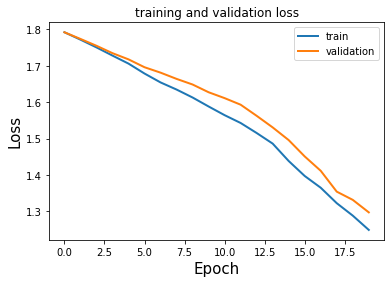

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

train_loss = np.load('./saved_models/best models/task1/train_loss.npy')
val_loss = np.load('./saved_models/best models/task1/val_loss.npy')
print('val loss:', val_loss[-1])
print('train loss:', train_loss[-1])
plt.plot(train_loss, linewidth=2, label='train')
plt.plot(val_loss, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.title('training and validation loss')

val accuracy: 0.6816816816816816
train accuracy: 0.7185778668002003


Text(0.5, 1.0, 'training and validation Accuracy')

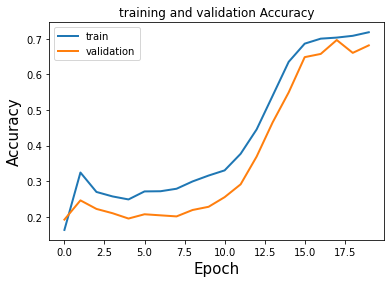

In [70]:
val_acc = np.load('./saved_models/task1/val_acc.npy')
train_acc = np.load('./saved_models/task1/train_acc.npy')
print('val accuracy:', val_acc[-1])
print('train accuracy:', train_acc[-1])
plt.plot(train_acc, linewidth=2, label='train')
plt.plot(val_acc, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title('training and validation Accuracy')